### General Usage Example for the `optimex` Package

`optimex` is a Python package for transition pathway optimization based on time-explicit Life Cycle Assessment (LCA). It helps identify optimal process portfolios and deployment timing in systems with multiple processes producing the same product, aiming to minimize dynamically accumulating environmental impacts over time.

`optimex` builds on top of the optimization framework [pyomo](https://github.com/Pyomo/pyomo) and the LCA framework [Brightway](https://docs.brightway.dev/en/latest).

Before using `optimex`, you need to set up a Brightway project. Brightway manages LCA databases, calculates impacts, and allows detailed environmental analysis.

In [1]:
from datetime import datetime
import numpy as np
import bw2data as bd
from bw_temporalis import TemporalDistribution

bd.projects.set_current("standalone_optimex_example")

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


### Required Brightway Databases: Biosphere

`optimex` requires a biosphere database listing elementary flows, typically imported from databases like ecoinvent. Here, we create a custom biosphere database named **biosphere3**, which is the standard name expected by `optimex`.

We also explicitly specify Chemical Abstracts Service (CAS) numbers for corresponding flows (in ecoinvent these are already attached) , which will assist in later characterization steps.


In [2]:

# BIOSPHERE
biosphere_data = {
    ("biosphere3", "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "CAS number": "000124-38-9"
    },
    ("biosphere3", "CH4"): {
        "type": "emission",
        "name": "methane, fossil",
        "CAS number": "000074-82-8"
    },
}
bd.Database("biosphere3").write(biosphere_data)

100%|██████████| 2/2 [00:00<00:00, 3898.05it/s]

10:53:21+0100 [info     ] Vacuuming database            



When conducting a Life Cycle Assessment (LCA) using `optimex`, the system is divided into two conceptual parts:

- **Foreground system**: The set of processes that are directly controlled, designed, or influenced by the decision-maker. These processes are typically the focus of modeling and change, and they represent the core of the decision or innovation being studied. In `optimex`, the foreground system consists of candidate processes whose installation and operation timings are optimized to meet a functional demand while minimizing environmental impact.

- **Background system**: The system of processes that supply inputs to the foreground system but are not affected by decisions within the scope of the study. These are typically taken from external LCA databases (e.g., ecoinvent) and represent average or generic data for energy, materials, transport, etc. In `optimex`, these background processes provide the upstream data and remain unaffected by the optimization.


### Required Databases: Background

Altough the background system is not affected by decision making in the foreground system, it will gradually **change over time** due to technological progress or policy shifts.

To reflect this temporal evolution, we define **multiple background databases** at different time points (e.g., 2020, 2030, 2040). For extensive modelling the python package `premise` offfers the ability to modify ecoinvent databases according to projected scenario pathways. 

During optimization, `optimex` dynamically links each process to the appropriate background database according to its temporal profile, ensuring that background data reflects the timing of each exchange within the process lifecycle.

For `optimex` to recognize the representative time of each background version, we store the corresponding date in the database metadata:


In [3]:

# BACKGROUND 2020
db_2020_data = {
    ("db_2020", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I1")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2020", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2020", "I2")},
            {"amount": 1, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2020 = bd.Database("db_2020")
bg_2020.write(db_2020_data)
bg_2020.metadata["representative_time"] = datetime(2020, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2020.register()

# BACKGROUND 2030
db_2030_data = {
    ("db_2030", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "reference product": "I1",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I1")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CO2")},
        ],
    },
    ("db_2030", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "reference product": "I2",
        "exchanges": [
            {"amount": 1, "type": "production", "input": ("db_2030", "I2")},
            {"amount": 0.9, "type": "biosphere", "input": ("biosphere3", "CH4")},
        ],
    },
}
bg_2030 = bd.Database("db_2030")
bg_2030.write(db_2030_data)
bg_2030.metadata["representative_time"] = datetime(2030, 1, 1).isoformat() # optimex-specific: representative time of the background database
bg_2030.register()


10:53:21+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 35696.20it/s]

10:53:21+0100 [info     ] Vacuuming database            
10:53:21+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 2/2 [00:00<00:00, 21076.90it/s]

10:53:21+0100 [info     ] Vacuuming database            



### Required Databases: Foreground
Time-Explicit Modeling in the Foreground

`optimex` extends traditional LCA by explicitly modeling time, which enables modelling of flows at the actual occurence in the process life cycle. To process this information we need to define temporal distributions of the flows correspodning the foreground processes using `TemporalDistribution` again.

For example, consider a process `P1` that produces a product `R1` over a 4-year lifecycle:

- **Year 0 (Pre-operation)**: The process is installed (constructed). It does not produce any output but consumes an input `I1`.  
- **Years 1 and 2 (Operation phase)**: The process produces 0.5 units of `R1` each year and emits CO₂ accordingly.  
- **Year 3 (Post-operation)**: The process is decommissioned and does not exchange anything.

The time-explicit modelling, also allows installation of a process and then operation at different capacity levels at the following time steps. To enable flexible operation we explictly need to tell `optimex` the time limits of the operation phase (start and end of operation phase) for each process. Intermediate and elementary flows that are exchanged during operation, which are scaling relative to the operation level (e.g., production output, emissions during operation) need to be marked with `"operation": True`. Flexible operation is particularly useful in time-explicit LCA, as it allows the model to install a capacity once and operate it differently across its lifespan — offering realistic modelling of transition pathways.

In the following definition of a foreground database, all additional information `optimex` requires in comparison to a default brightway databse is commented.

In [4]:

# FOREGROUND - temporally distributed
foreground_data = {
    ("foreground", "Product 1"): {
        "name": "Product 1",
        "unit": "kg",
        "type": bd.labels.product_node_default,
    },
    ("foreground", "P1"): {
        "name": "process P1",
        "location": "somewhere",
        "type":  bd.labels.process_node_default,
        "operation_time_limits": (1,2), # Optimex-specific: start and end year of operation phase
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True, # Optimex-specific: indicates that this exchange is part of the operation phase
            },
            {
                "amount": 27.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution( # Optimex-specific: temporal distribution of the exchange)
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P2"): {
        "name": "process P2",
        "location": "somewhere",
        "type":  bd.labels.process_node_default,
        "operation_time_limits": (1,2),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([1, 0, 0, 0]),
                ),
            },
            {
                "amount": 20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array(range(4), dtype="timedelta64[Y]"),
                    amount=np.array([0, 0.5, 0.5, 0]),
                ),
                "operation": True,
            },
        ],
    },
}
fg = bd.Database("foreground")
fg.write(foreground_data)
fg.register()

10:53:21+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 3/3 [00:00<00:00, 6291.46it/s]

10:53:21+0100 [info     ] Vacuuming database            


### Characterization Methods

To quantify environmental impact, we need to define **characterization factors** (CFs) for each elementary flow—such as CO₂ or CH₄ emissions. These CFs convert emissions into impact scores (e.g., in kg CO₂-eq).

> 🔎 Note: If you're using a full database like **ecoinvent**, characterization methods (e.g. IPCC, ReCiPe) are usually already included.  
> But since we're creating a custom biosphere here, we need to define our own CFs manually.


In [5]:
bd.Method(("GWP", "example")).write([
    (("biosphere3", "CO2"), 1),
    (("biosphere3", "CH4"), 27),
])

bd.Method(("land use", "example")).write([
    (("biosphere3", "CO2"), 2),
    (("biosphere3", "CH4"), 1),
])

### Dynamic Characterization in `optimex`

One of the key advantages of `optimex` is its ability to perform **dynamic characterization**—assessing environmental impacts in a way that accounts for **when emissions occur**, not just how much is emitted. This is particularly relevant for impact categories like **climate change**, where environmental impact is influenced by timing and amount of emissions.

*Why Use Dynamic Characterization?*

In conventional (static) LCA, the timing of emissions is ignored—1 kg of CO₂ emitted today is treated the same as 1 kg emitted 50 years from now.  
Dynamic characterization allows `optimex` to differentiate these cases by using **time-resolved impact factors**, which in the context of climate change take atmospheric acummulation and decay of green house gases into account, providing a more accurate modelling approach of long-term environmental effects.

Currently, `optimex` supports dynamic modeling for climate change through the following metrics:

- **CRF** – Cumulative Radiative Forcing  
- **GWP** – Global Warming Potential (time-sensitive)

These metrics are implemented via the [`dynamic_characterization`](https://github.com/brightway-lca/dynamic_characterization) package.

> 📌 Note: Only climate change metrics are currently supported for dynamic impact assessment.

### Defining Demand of Functional Unit in `optimex`

Before we can process our LCA data in `optimex`, we need to define a temporally distiributed demand of our functional unit.  

The demand describes how much of the functional product (e.g., `"R1"`) is needed each year across the time horizon of interest. This is defined using a `TemporalDistribution`, which allows you to assign specific demand values to individual dates.

By explicitly modeling how demand changes over time, `optimex` can optimize not only which processes to use but also when to install and operate them.

In [6]:
# Define temporally distributed demand from 2020 to 2030
years = range(2020, 2030)
td_demand = TemporalDistribution(
    date=np.array([datetime(year, 1, 1).isoformat() for year in years], dtype='datetime64[s]'),
    amount=np.asarray([0, 0, 10, 5, 10, 5, 10, 5, 10, 5]),
)
product_1 = bd.get_node(database="foreground", name="Product 1")
functional_demand = {product_1: td_demand}

### Configuring LCA Processing in `optimex`

To process all the data defined before with `optimex`, we need to configure both **temporal parameters** and **characterization methods**.

**Minimum requirements:**

1. Pass the defined demand

2. Define a valid `temporal` parameters, including:
   - A `start_date` (e.g., start of system transiition and impact assessment).
   - A `temporal_resolution` (e.g., `"year"`).
   - A `time_horizon` over which impacts are accumulated.

3. In the `characterization_methods`, specify:
   - A `metric` that supports dynamic characterization in the choosen impact category (e.g., `"CRF"` as cumulative radiative forcing for climate change).
   - The associated `brightway_method` for conventional impact factors (used for preprocessing or for static categories).

If no dynamic metric is specified for a category, `optimex` will default to **static characterization** using the standard Brightway impact method.

The example below demonstrates how to configure dynamic climate change modeling with `"CRF"` and a static method for land use:



In [7]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand = functional_demand ,
    temporal= {
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": ("GWP", "example"),
            "metric": "CRF",
        },
        {
            "category_name": "land_use",
            "brightway_method": ("land use", "example"),
        },
    ],
)

With all the necessary components defined, we are now ready to gather the LCI and prepare for optimization.

To summarize, we have:

- Defined a **custom biosphere** with elementary flows (e.g., CO₂, CH₄).
- Created **foreground** and **background** systems, including temporal distributions.
- Registered **characterization methods** (static or dynamic).
- Specified **demand over time** using `TemporalDistribution`.
- Marked processes as **functional flows** to indicate eligible supply routes.
- (Optionally) Enabled **dynamic characterization** for more time-sensitive impact assessment.

In [8]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-12-08 10:53:21.603 | INFO     | optimex.lca_processor:_parse_demand:326 - Identified demand in system time range of %s for functional flows %s
2025-12-08 10:53:21.610 | INFO     | optimex.lca_processor:_construct_foreground_tensors:449 - Constructed foreground tensors.
2025-12-08 10:53:21.612 | INFO     | optimex.lca_processor:log_tensor_dimensions:444 - Technosphere shape: (2 processes, 2 flows, 4 years) with 8 total entries.
2025-12-08 10:53:21.612 | INFO     | optimex.lca_processor:log_tensor_dimensions:444 - Biosphere shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-12-08 10:53:21.613 | INFO     | optimex.lca_processor:log_tensor_dimensions:444 - Production shape: (2 processes, 1 flows, 4 years) with 8 total entries.
2025-12-08 10:53:21.613 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:487 - Calculating inventory for database: db_2020
2025-12-08 10:53:21.613 | WARNING  | optimex.lca_processor:_calculate_inventory_of_db:498 - Failed to get activ

### Saving and Reusing Model Inputs

Gathering all LCA-relevant data—including biosphere flows, foreground and background systems, temporal distributions, and characterization methods—can be **computationally expensive**.  
If you're working with similar scenarios or want to explore different optimization settings, it's often unnecessary to rebuild the entire setup from scratch.

 `OptimizationModelInputs`: Interface for Efficient Reuse

To address this, `optimex` provides a dedicated interface called **`OptimizationModelInputs`**. This object:

- Collects all the structured LCA data needed for optimization.
- Can be **saved** to disk for future use.
- Can be **loaded** later to resume or modify the scenario.
- Allows you to tweak configurations (e.g., demand, technologies, time horizon) without re-running the full data setup.

In the next steps, we’ll create and populate a `OptimizationModelInputs` object, and use it to prepare for running the optimization in `optimex`.

In [9]:
from optimex import converter
manager = converter.ModelInputManager()

In [10]:
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 
# manager.save("model_inputs.json") # if you want to save the model inputs to a file
# manager.load("model_inputs.json") # if you want to load the model inputs from a file
optimization_model_inputs.model_dump()

{'PROCESS': ['P1', 'P2'],
 'PRODUCT': ['Product 1', 'I1', 'I2'],
 'ELEMENTARY_FLOW': ['CO2', 'CH4'],
 'BACKGROUND_ID': ['db_2020', 'db_2030'],
 'PROCESS_TIME': [0, 1, 2, 3],
 'SYSTEM_TIME': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029],
 'CATEGORY': ['land_use', 'climate_change'],
 'demand': {('Product 1', 2020): 0.0,
  ('Product 1', 2021): 0.0,
  ('Product 1', 2022): 10.0,
  ('Product 1', 2023): 5.0,
  ('Product 1', 2024): 10.0,
  ('Product 1', 2025): 5.0,
  ('Product 1', 2026): 10.0,
  ('Product 1', 2027): 5.0,
  ('Product 1', 2028): 10.0,
  ('Product 1', 2029): 5.0},
 'operation_flow': {('P1', 'Product 1'): True,
  ('P1', 'CO2'): True,
  ('P2', 'Product 1'): True,
  ('P2', 'CO2'): True},
 'foreground_technosphere': {('P1', 'I1', 0): 27.5,
  ('P1', 'I1', 1): 0.0,
  ('P1', 'I1', 2): 0.0,
  ('P1', 'I1', 3): 0.0,
  ('P2', 'I2', 0): 1.0,
  ('P2', 'I2', 1): 0.0,
  ('P2', 'I2', 2): 0.0,
  ('P2', 'I2', 3): 0.0},
 'foreground_biosphere': {('P1', 'CO2', 0): 0.0,
  ('P1', 'CO2',

### Creating the Optimization Model

With the `OptimizationModelInputs` object prepared, we can now **populate the optimization model** in `optimex`.

This step involves specifying:

- A **name** for the model,
- The **impact category** to be minimized (e.g., `"climate_change"`),
- Whether to enable **flexible operation** (i.e., allow processes to run at varying capacity over time).


In [11]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = True, # Feel free to change this to see both
)

2025-12-08 10:53:22.163 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-12-08 10:53:22.164 | INFO     | optimex.optimizer:create_model:107 - Creating parameters
2025-12-08 10:53:22.165 | INFO     | optimex.optimizer:create_model:270 - Creating variables


## Solving the Optimization Model

Once the model is created, you can solve it using available solvers such as **GLPK** or **Gurobi**.

Use the `solve_model` function from `optimex` to run the optimization. It offers several parameters to control solver options, convergence criteria, and output verbosity.

For detailed information on all parameters and solver configurations, please refer to the documentation.

In [12]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-12-08 10:53:22.206 | INFO     | optimex.optimizer:solve_model:636 - Solver [glpk] termination: optimal
2025-12-08 10:53:22.208 | INFO     | optimex.optimizer:solve_model:661 - Objective (scaled): 1.61489
2025-12-08 10:53:22.208 | INFO     | optimex.optimizer:solve_model:662 - Objective (real):   1.05036e-10


## Postprocessing the Optimization Results

`optimex` offers powerful tools to analyze and visualize the optimal solution in detail. Key aspects you can explore include:

- **Impact over time:** View time-resolved environmental impacts according to the chosen impact category.
- **Demand fulfillment:** Track how the demand for the functional product evolves and by which processes it is met during the modeled period.
- **Installation timeline:** Identify when each process was installed during the transition pathway.
- **Operation profiles:** Examine the operational levels of processes year-by-year, especially important for flexible operation scenarios.
- **Production of functional flows:** Analyze how much of the functional product each process produces over time.

Together, these outputs provide a comprehensive understanding of the system’s dynamics, helping you evaluate trade-offs and the timing of interventions. Below is a demosntartion of some postprocessing tools.


In [13]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

df_impact = pp.get_impacts()
df_impact

Category   land_use            climate_change              
Process          P1         P2             P1            P2
Time                                                       
2020       0.000000   0.000000   0.000000e+00  0.000000e+00
2021       0.000000   0.013091   0.000000e+00  3.096157e-14
2022       0.000000  14.545455   0.000000e+00  6.338993e-13
2023       0.000000   7.285554   0.000000e+00  3.447250e-13
2024       0.000000  14.545455   0.000000e+00  6.236494e-13
2025       0.690909   7.272727   2.937901e-14  3.092528e-13
2026      14.545455   0.000000   6.133488e-13  0.000000e+00
2027       7.949091   0.000000   3.323698e-13  0.000000e+00
2028      14.545455   0.000000   6.029959e-13  0.000000e+00
2029       7.272727   0.000000   2.988997e-13  0.000000e+00

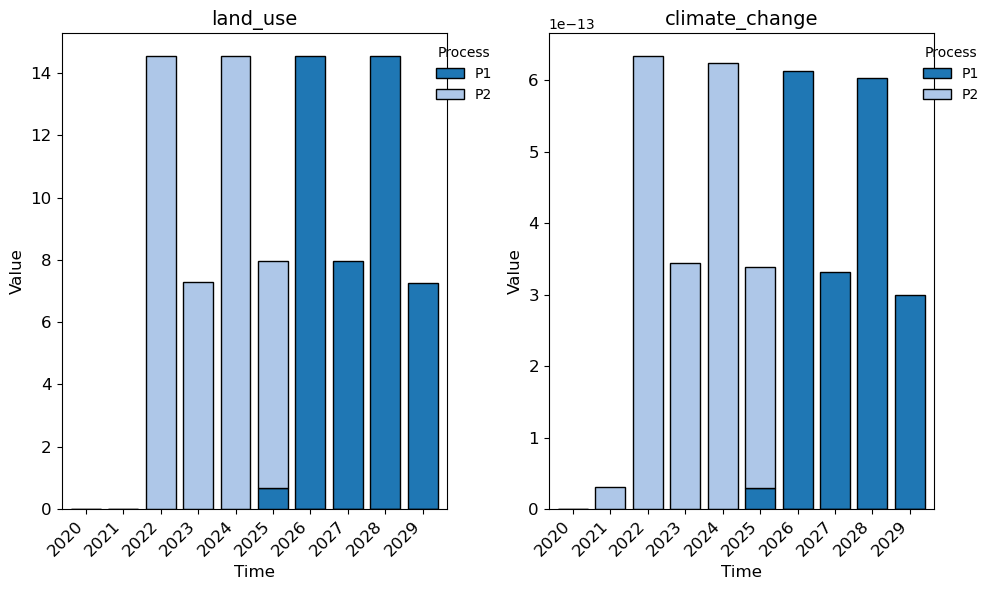

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'land_use'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [14]:
pp.plot_impacts()

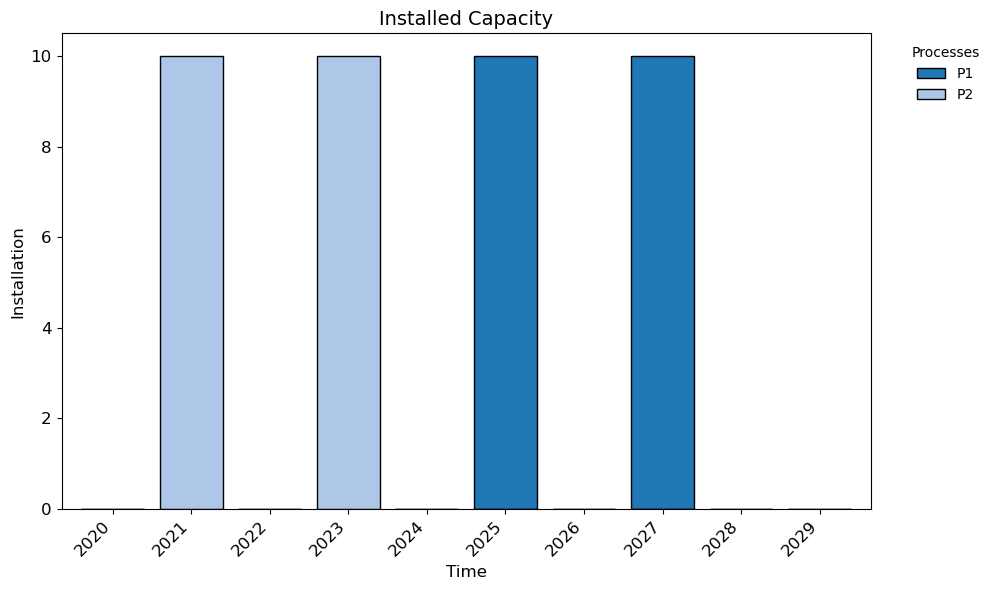

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [15]:
pp.plot_installation()


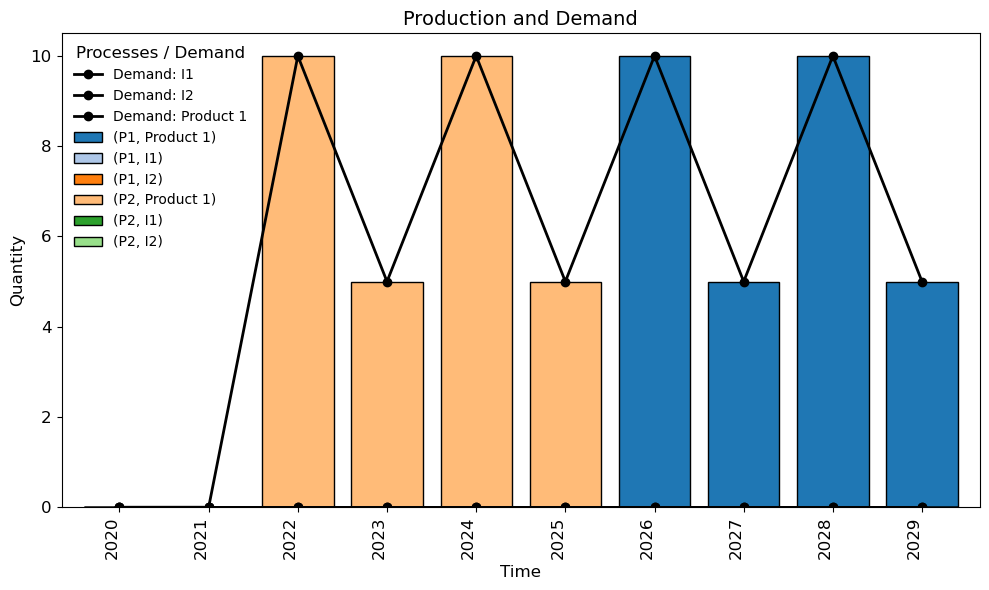

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [16]:
pp.plot_production_and_demand()